In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

In [61]:
np.random.seed(0) 
n_samples = 1000
X = np.random.randn(n_samples, 3)
Z = np.random.randn(n_samples)
T = 2 * X[:, 0] - X[:, 1] + 3 * Z + np.random.normal(0, 1, size=n_samples)
Y = 1 + 2 * X[:, 1] - X[:, 2] + 3 * T + np.random.normal(0, 1, size=n_samples)


X_train, X_test, T_train, T_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, T, Y, Z, test_size=0.2, random_state=0)

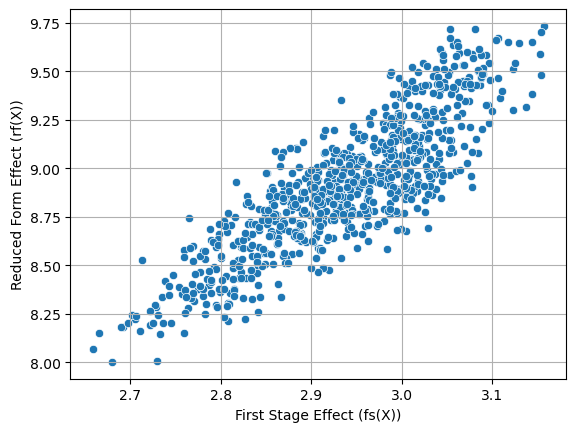

Correlation coefficient between first stage and reduced form: 0.855058253892476
Spearman's rank correlation coefficient: 0.8368212372206831
Kendall's tau rank correlation coefficient: 0.6493304130162704


In [62]:
causal_forest_fs = CausalForestDML(discrete_treatment=False)
causal_forest_fs.fit(T_train, Z_train, X=X_train, W=None)
fs_cate = causal_forest_fs.effect(X_train)

causal_forest_rf = CausalForestDML(discrete_treatment=False)
causal_forest_rf.fit(Y_train, Z_train, X=X_train, W=None)
rf_cate = causal_forest_rf.effect(X_train)

sns.scatterplot(x=fs_cate, y=rf_cate)
plt.xlabel('First Stage Effect (fs(X))')
plt.ylabel('Reduced Form Effect (rf(X))')
plt.grid(True)
plt.show()

corr = np.corrcoef(fs_cate, rf_cate)[0, 1]
print("Correlation coefficient between first stage and reduced form:", corr)

spearman_corr, _ = scipy.stats.spearmanr(fs_cate, rf_cate)
print("Spearman's rank correlation coefficient:", spearman_corr)

kendall_corr, _ = scipy.stats.kendalltau(fs_cate, rf_cate)
print("Kendall's tau rank correlation coefficient:", kendall_corr)

In [64]:
tsls = IV2SLS(Y_train, T_train, Z_train).fit()
# tsls.summary()
r2_tsls = tsls.rsquared
print("R-squared for tsls model:", r2_tsls)

R-squared for tsls model: 0.9471233860667072


0.1 0.1
0.1 0.35789473684210527
0.1 0.6157894736842106
0.1 0.8736842105263158
0.1 1.1315789473684212
0.1 1.3894736842105266
0.1 1.6473684210526318
0.1 1.905263157894737
0.1 2.1631578947368424
0.1 2.421052631578948
0.1 2.678947368421053
0.1 2.936842105263158
0.1 3.1947368421052635
0.1 3.452631578947369
0.1 3.710526315789474
0.1 3.9684210526315793
0.1 4.226315789473684
0.1 4.484210526315789
0.1 4.742105263157895
0.1 5.0
0.35789473684210527 0.1
0.35789473684210527 0.35789473684210527
0.35789473684210527 0.6157894736842106
0.35789473684210527 0.8736842105263158
0.35789473684210527 1.1315789473684212
0.35789473684210527 1.3894736842105266
0.35789473684210527 1.6473684210526318
0.35789473684210527 1.905263157894737
0.35789473684210527 2.1631578947368424
0.35789473684210527 2.421052631578948
0.35789473684210527 2.678947368421053
0.35789473684210527 2.936842105263158
0.35789473684210527 3.1947368421052635
0.35789473684210527 3.452631578947369
0.35789473684210527 3.710526315789474
0.35789473684

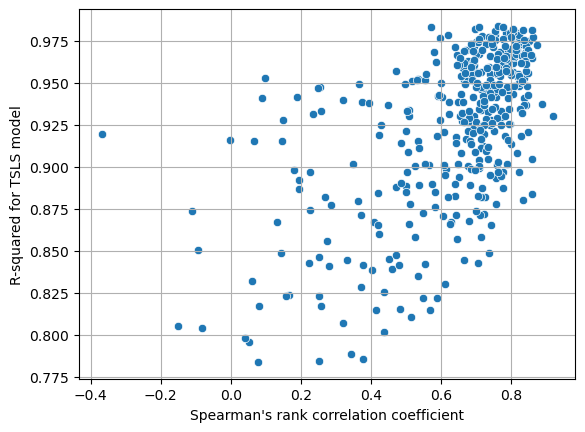

In [68]:
corrs = []
r2s = []

for sigma_1 in np.linspace(0.1, 5, 20):
    for sigma_2 in np.linspace(0.1, 5, 20):
        print(sigma_1, sigma_2)
        T = 2 * X[:, 0] - X[:, 1] + 3 * Z + np.random.normal(0, sigma_1, size=n_samples)
        Y = 1 + 2 * X[:, 1] - X[:, 2] + 3 * T + np.random.normal(0, sigma_2, size=n_samples)
        X_train, X_test, T_train, T_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, T, Y, Z, test_size=0.2, random_state=0)

        causal_forest_fs = CausalForestDML(discrete_treatment=False)
        causal_forest_fs.fit(T_train, Z_train, X=X_train, W=None)
        fs_cate = causal_forest_fs.effect(X_train)

        causal_forest_rf = CausalForestDML(discrete_treatment=False)
        causal_forest_rf.fit(Y_train, Z_train, X=X_train, W=None)
        rf_cate = causal_forest_rf.effect(X_train)

        spearman_corr, _ = scipy.stats.spearmanr(fs_cate, rf_cate)
        corrs.append(spearman_corr)

        tsls = IV2SLS(Y_train, T_train, Z_train).fit()
        r2s.append(tsls.rsquared)

sns.scatterplot(x=corrs, y=r2s)
plt.xlabel("Spearman's rank correlation coefficient")
plt.ylabel("R-squared for TSLS model")
plt.grid(True)
plt.show()